In [17]:
import datetime
from pathlib import Path
from string import ascii_lowercase, ascii_uppercase

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from numba import boolean, float32, float64, guvectorize, jit

from scipy import stats
import scipy.optimize


In [18]:
@guvectorize(
    [
        (float64[:], float64[:], float64[:], boolean, float64[:]),
        (float32[:], float32[:], float32[:], boolean, float32[:]),
    ],
    "(n),(n),(m),()->(m)",
    nopython=True,
)
def _interp_1d_linear(phi, theta, target_theta_levels, mask_edges, output):
    # if last theta value is smaller than first, assume the profile is monotonically decreasing and flip
    if theta[-1] < theta[0]:
        theta = np.flip(theta)
        phi = np.flip(phi)

    output[:] = np.interp(target_theta_levels, theta, phi)

    if mask_edges:
        theta_max = np.nanmax(theta)
        theta_min = np.nanmin(theta)
        for i in range(len(target_theta_levels)):
            theta_lev = target_theta_levels[i]
            if (theta_lev < theta_min) or (theta_lev > theta_max):
                output[i] = np.nan


def interp_1d_linear(phi, theta, target_theta_levels, mask_edges=True):
    """
    Vectorized interpolation of scalar phi to isosurfaces of scalar theta
    along the final axis.
    Parameters
    ----------
    phi : array_like
        Array of shape (..., n), scalar field to be interpolated
    theta : array_like
        Array of shape (..., n), scalar field which defines the isosurfaces
    target_theta_levels : array_like
        Array of shape (m) specificying target isosurface levels
    mask_edges : bool, optional
        Determines how to handle theta values that exceed the bounds of
        target_theta_levels. If False, fill with nearest valid values. If
        True, fill with NaNs.
    Returns
    -------
    phi_interp : array
        Array of shape (..., m) of phi interpolated to theta isosurfaces.
    """
    return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


def linear_interpolation(
    phi, theta, target_theta_levels, phi_dim, theta_dim, target_dim, **kwargs
):
    out = xr.apply_ufunc(
        interp_1d_linear,
        phi,
        theta,
        target_theta_levels,
        kwargs=kwargs,
        input_core_dims=[[phi_dim], [theta_dim], [target_dim]],
        output_core_dims=[[target_dim]],
        exclude_dims=set((phi_dim,)),
        dask="parallelized",
        output_dtypes=[np.float32],
    )
    out[target_dim] = target_theta_levels
    return out


EARTH_RADIUS = 6371000.0  # m


def _guess_bounds(points, bound_position=0.5):
    """
    Guess bounds of grid cells.

    Simplified function from iris.coord.Coord.

    Parameters
    ----------
    points: numpy.array
        Array of grid points of shape (N,).
    bound_position: float, optional
        Bounds offset relative to the grid cell centre.
    Returns
    -------
    Array of shape (N, 2).
    """
    diffs = np.diff(points)
    diffs = np.insert(diffs, 0, diffs[0])
    diffs = np.append(diffs, diffs[-1])

    min_bounds = points - diffs[:-1] * bound_position
    max_bounds = points + diffs[1:] * (1 - bound_position)

    return np.array([min_bounds, max_bounds]).transpose()


def _quadrant_area(radian_lat_bounds, radian_lon_bounds, radius_of_earth):
    """
    Calculate spherical segment areas.
    Taken from SciTools iris library.
    Area weights are calculated for each lat/lon cell as:
        .. math::
            r^2 (lon_1 - lon_0) ( sin(lat_1) - sin(lat_0))
    The resulting array will have a shape of
    *(radian_lat_bounds.shape[0], radian_lon_bounds.shape[0])*
    The calculations are done at 64 bit precision and the returned array
    will be of type numpy.float64.
    Parameters
    ----------
    radian_lat_bounds: numpy.array
        Array of latitude bounds (radians) of shape (M, 2)
    radian_lon_bounds: numpy.array
        Array of longitude bounds (radians) of shape (N, 2)
    radius_of_earth: float
        Radius of the Earth (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas of shape (M, N).
    """
    # ensure pairs of bounds
    if (
        radian_lat_bounds.shape[-1] != 2
        or radian_lon_bounds.shape[-1] != 2
        or radian_lat_bounds.ndim != 2
        or radian_lon_bounds.ndim != 2
    ):
        raise ValueError("Bounds must be [n,2] array")

    # fill in a new array of areas
    radius_sqr = radius_of_earth**2
    radian_lat_64 = radian_lat_bounds.astype(np.float64)
    radian_lon_64 = radian_lon_bounds.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)

    # we use abs because backwards bounds (min > max) give negative areas.
    return np.abs(areas)


def grid_cell_areas(lon1d, lat1d, radius=EARTH_RADIUS):
    """
    Calculate grid cell areas given 1D arrays of longitudes and latitudes
    for a planet with the given radius.

    Parameters
    ----------
    lon1d: numpy.array
        Array of longitude points [degrees] of shape (M,)
    lat1d: numpy.array
        Array of latitude points [degrees] of shape (M,)
    radius: float, optional
        Radius of the planet [metres] (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas [metres**2] of shape (M, N).
    """
    lon_bounds_radian = np.deg2rad(_guess_bounds(lon1d))
    lat_bounds_radian = np.deg2rad(_guess_bounds(lat1d))
    area = _quadrant_area(lat_bounds_radian, lon_bounds_radian, radius)
    return area


def process(ds, deseasonalize=True):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2022-01", freq="M", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(1, 100))

def process_daily(ds, deseasonalize=False):
    ds = ds.drop_vars(["var152", "time_bnds", "lat_bnds"], errors="ignore")
    ds["time"] = pd.date_range("2021-01", freq="D", periods=ds.time.shape[0])
    ds["plev"] = ds.plev.values / 100.0
    ds["plev"].attrs["units"] = "hPa"
    ds["plev"].attrs["long_name"] = "pressure"
    ds["plev"].attrs["standard_name"] = "pressure"

    if deseasonalize:
        ds = anomalize_func(ds)  # deseasonalize_func(ds)

    return ds.sel(plev=slice(1, 100))#, time = slice('2022-01','2022-12'))


def integrate_wv(da):
    g = 9.81
    e = 0.622
    w = area_weights  # .mean(axis = 1)
    # from kg to g and then to Tg
    integral = (da * w * plev_diff * e / g).sum(["lat", "plev", "lon"]) * 1000 / 1e12

    return integral

def preprocess(ds, sel_var = ['QV']):
    ds_sel = ds[sel_var]
    return ds_sel

In [3]:
from dask.distributed import LocalCluster

# https://forum.access-hive.org.au/t/netcdf-not-a-valid-id-errors/389/12
cluster = LocalCluster(threads_per_worker=1)          # Fully-featured local Dask cluster
client = cluster.get_client()
client

/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35375 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35375/status,
Dashboard: http://127.0.0.1:35375/status,Workers: 56
Total threads: 56,Total memory: 755.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34809,Workers: 56
Dashboard: http://127.0.0.1:35375/status,Total threads: 56
Started: Just now,Total memory: 755.78 GiB
Comm: tcp://127.0.0.1:38901,Total threads: 1
Dashboard: http://127.0.0.1:37055/status,Memory: 13.50 GiB
Nanny: tcp://127.0.0.1:33725,


In [58]:
global_burden = xr.open_mfdataset(
    ['M2SCREM_WV-burden_2022.nc','M2SCREM_WV-burden_2023.nc'],
    concat_dim='time',
    combine="nested",
    parallel=True
)['iWV'].load()
global_burden

Task exception was never retrieved
future: <Task finished name='Task-24932638' coro=<Client._gather.<locals>.wait() done, defined at /hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-24932637' coro=<Client._gather.<locals>.wait() done, defined at /hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/hpx/Data_impb/kales/conda/envs/myenv/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-24932636' coro=<Client._gather.<l

KeyboardInterrupt: 

In [60]:
global_burden23 = xr.open_dataset('M2SCREM_WV-burden_2023.nc')['iWV']
global_burden23

<xarray.DataArray 'iWV' (time: 2920)> Size: 23kB
[2920 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 23kB 2023-01-01 ... 2023-12-31T21:00:00

In [59]:
global_burden = xr.open_dataset('M2SCREM_WV-burden_2022.nc')['iWV']
global_burden

<xarray.DataArray 'iWV' (time: 2920)> Size: 23kB
[2920 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 23kB 2022-01-01 ... 2022-12-31T21:00:00

In [64]:
global_burden_all = xr.merge([global_burden, global_burden23])['iWV']
global_burden_all

<xarray.DataArray 'iWV' (time: 5840)> Size: 47kB
array([1593.35704042, 1593.55763047, 1592.99049525, ..., 1790.05211794,
       1789.75427509, 1789.50425298])
Coordinates:
  * time     (time) datetime64[ns] 47kB 2022-01-01 ... 2023-12-31T21:00:00

In [25]:
what = "H2O_m"
infile_path_socol = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
infiles_w = list(infile_path_socol.glob(f"socol4_htt1*{what}*"))
infiles_wo = list(infile_path_socol.glob(f"socol4_htt2*{what}*"))
infiles_wo

[PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt23_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt22_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt20_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt21_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt24_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt25_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt27_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt26_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt28_H2O_m_2021-2025_daily.nc'),
 PosixPath('/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/socol4_htt29_H2O_m_2021-2025_daily.nc')]

In [19]:
ds_w_wv = xr.open_mfdataset(
    infiles_w,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
    chunks = dict(plev = 1, time = 365, ens = 1)
).pipe(
    process_daily, deseasonalize=False
)  # .chunk(plev = 1, time = 365)
# ds_w_wv["ens"] = ens_name_ls
ds_w_wv

<xarray.Dataset> Size: 23GB
Dimensions:  (time: 1826, lon: 192, lat: 96, plev: 17, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2021-01-01 2021-01-02 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 136B 1.0 1.215 1.929 2.957 ... 74.06 91.02 100.0
Dimensions without coordinates: ens
Data variables:
    H2O_m    (ens, time, plev, lat, lon) float32 23GB dask.array<chunksize=(1, 365, 1, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Feb 26 14:43:50 2024: cdo cat rr3.nc /scratch/snx3000/a...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [20]:
ds_wo_wv = xr.open_mfdataset(
    infiles_wo,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
    chunks = dict(plev = 1, time = 365, ens = 1)
).pipe(process_daily, deseasonalize=False)
ds_wo_wv

<xarray.Dataset> Size: 23GB
Dimensions:  (time: 1826, lon: 192, lat: 96, plev: 17, ens: 10)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2021-01-01 2021-01-02 ... 2025-12-31
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * plev     (plev) float64 136B 1.0 1.215 1.929 2.957 ... 74.06 91.02 100.0
Dimensions without coordinates: ens
Data variables:
    H2O_m    (ens, time, plev, lat, lon) float32 23GB dask.array<chunksize=(1, 365, 1, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Feb 26 16:11:55 2024: cdo cat rr3.nc /scratch/snx3000/a...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [26]:
lon = ds_w_wv["lon"]
lat = ds_w_wv["lat"]  # .values

area_weights = grid_cell_areas(lon, lat)  # , radius=radius)
plev_diff = ds_w_wv.plev.diff("plev") * 100  # in Pa
global_wv_w_ht = integrate_wv(ds_w_wv["H2O_m"]).load()
global_wv_wo_ht = integrate_wv(ds_wo_wv["H2O_m"]).load()

strat_WV_mass_htt-vs-M2SCREAM-vs-nudged_daily_202201-202212_daily.pdf


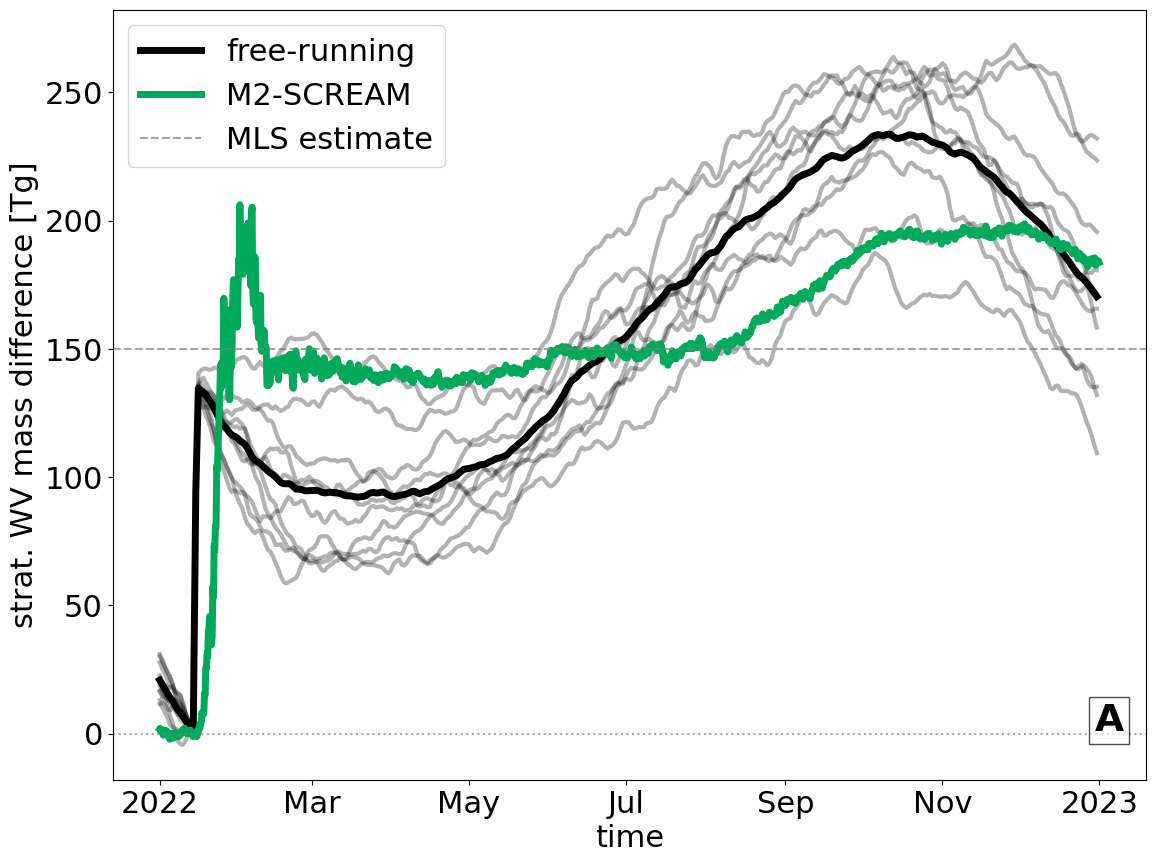

In [74]:
plt.rcParams.update({"font.size": 22})
index = 13

temp = global_wv_w_ht.sel(time=slice("2022-01-01", "2022-12-31"))  # .mean('ens')
temp_em = temp.mean("ens")
p = (temp - temp.sel(time = '2022-01-14')).plot.line(hue="ens", size=10, lw=3, c="k", alpha=0.3)
ax = p[0].axes
(temp_em - temp_em.sel(time = '2022-01-14')).plot.line(ax=ax, c="k", lw=5, label="free-running")

diff = global_burden_all.sel(time=slice("2022-01-01", "2022-12-31"))-global_burden_all.sel(time = '2022-01-14').mean()
diff.plot(c=(0, 170 / 255, 90 / 255), lw=5, label="M2-SCREAM", ax = ax)

ax.axhline(150, ls="--", c="gray", alpha=0.7, label="MLS estimate")
ax.axhline(0, ls=":", c="gray", alpha=0.7)
ax.legend()
ax.set_ylabel("strat. WV mass difference [Tg]")
ax.text(
    0.95,
    0.1,
    ascii_uppercase[0],
    transform=ax.transAxes,
    fontsize=27,
    fontweight="bold",
    va="top",
    bbox={"alpha": 0.7, "facecolor": "white"},
)

output = f"strat_WV_mass_htt-vs-M2SCREAM-vs-nudged_daily_202201-202212_daily.pdf"
print(output)
plt.savefig(output, bbox_inches="tight")